# Daten Importieren und vorbereiten

In [1]:
# import functions
import pandas as pd

# Read enriched dataset
data_enriched = pd.read_csv("data_enriched.csv", parse_dates=['Zeitstempel'])

In [2]:
# Zeitraum der Daten
print(data_enriched['Zeitstempel'].min())
print(data_enriched['Zeitstempel'].max())

# Drop ArtikelNr und Zeitstempel
data_enriched = data_enriched.drop(['ArtikelNr', 'Zeitstempel', 'Menge_log'], axis=1)

2018-01-02 00:00:00
2022-02-22 00:00:00


In [3]:
# Alle Artikel
all_articles = data_enriched['Artikel'].value_counts().index.tolist()
all_articles

['Laugen-Gipfel          of',
 'Butter-Gipfel / Croissant of',
 'caffè crema',
 'St. Galler Handbürli Culinarium *Gold prämiert*',
 'Körnergipfel of',
 'Weggli',
 'Mais-Gipfel of',
 'Sonnenblumenbrötli  of',
 'St. Galler Handb dk. Culinarium *Gold prämiert*',
 'Semmel                 of',
 'Nuss-Stengel Original',
 'Pain Roule rustico klein  of',
 'Gallusbrot 400   of',
 'Mais-Brötli süss   of',
 'Berliner m Confi Himbeer of',
 'Erdbeertörtli gross    ',
 'Butterzopf       440   2-teilig ',
 'Ziger-Krapfen          of']

# Alle Modelle Fine Tunen

In [4]:
# Funktionen importieren
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [5]:
# Function to calculate the score
def calculate_score(result):
    # Calculate score
    score = (0.6 * result['R2'] * (1 - result['MAPE']) * (1 / result['RMSE'])) + (0.2 * (1 - result['MAPE']) * (1 / result['RMSE'])) + (0.2 * result['R2'])
    return score

In [6]:
# Create dictionary for best_models
best_models = {}
# Dateframe for all metrics
all_results = pd.DataFrame()

# Define hyperparameters for random search
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 50],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.4, 1.0],
    'min_child_weight': [1, 4]
}

# Loop over articles
for artikel in all_articles:

    # Filter by Artikel
    data_filtered = data_enriched[data_enriched['Artikel'] == artikel].drop(['Artikel'], axis=1)

    X = data_filtered.drop(['Menge'], axis=1)
    y = data_filtered['Menge']

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

    models = [
        ('LinearRegression', LinearRegression(), {}),
        ('RandomForestRegressor', RandomForestRegressor(), rf_params),
        ('XGBRegressor', XGBRegressor(), xgb_params)
    ]

    # Initialize a variable to keep track of the best RMSE and corresponding model
    best_rmse = float('inf')
    best_model_info = None

    for name, model, params in models:

        if params:
            # Hyperparameter tuning using RandomizedSearchCV
            model_cv = RandomizedSearchCV(model, params, cv=5, n_iter=10, random_state=4153)
            model_cv.fit(X_train, y_train)
            best_model = model_cv.best_estimator_
        else:
            best_model = model
            best_model.fit(X_train, y_train)

        # Predict y
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Save results in a dictionary
        result = {'Artikel': artikel, 'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

        # Calculate score
        result['score'] = calculate_score(result)

        # Add to results dataframe
        all_results = pd.concat([all_results, pd.DataFrame([result])], ignore_index=True)    

        # If it's the best model so far, save it
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_info = {'model': best_model, 'metrics': result}
    
    # Save the best model for this artikel
    best_models[artikel] = best_model_info


In [ ]:
import pickle

# Saving the objects:
with open('best_models.pkl', 'wb') as f:  
    pickle.dump(best_models, f)

# Plot Results

### Our Score

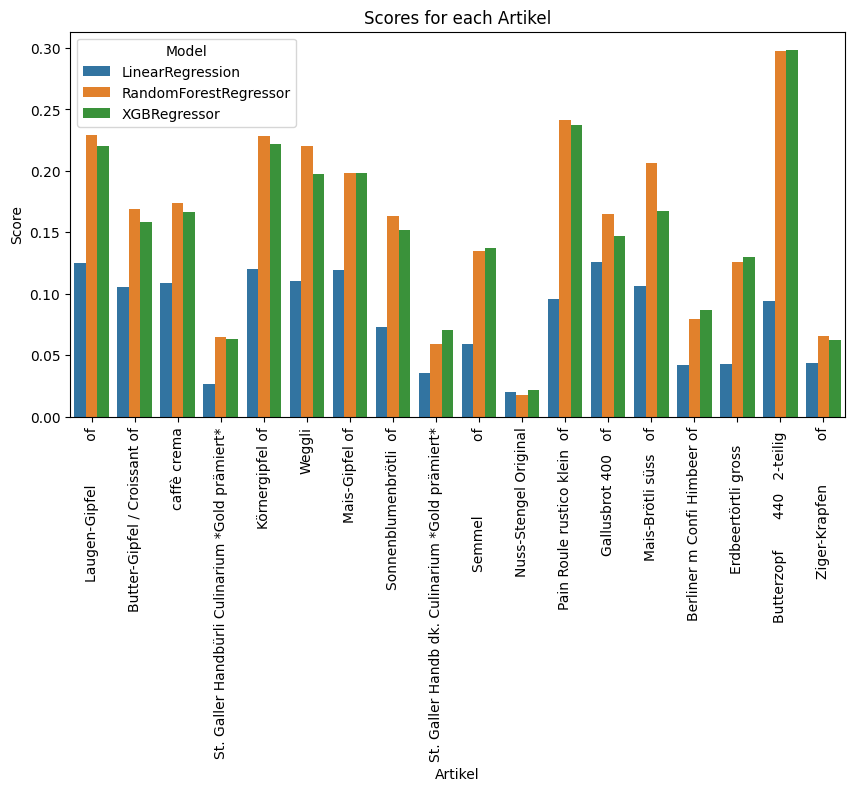

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='Artikel', y='score', hue='modelname')
plt.title('Scores for each Artikel')
plt.ylabel('Score')
plt.xlabel('Artikel')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

### R2

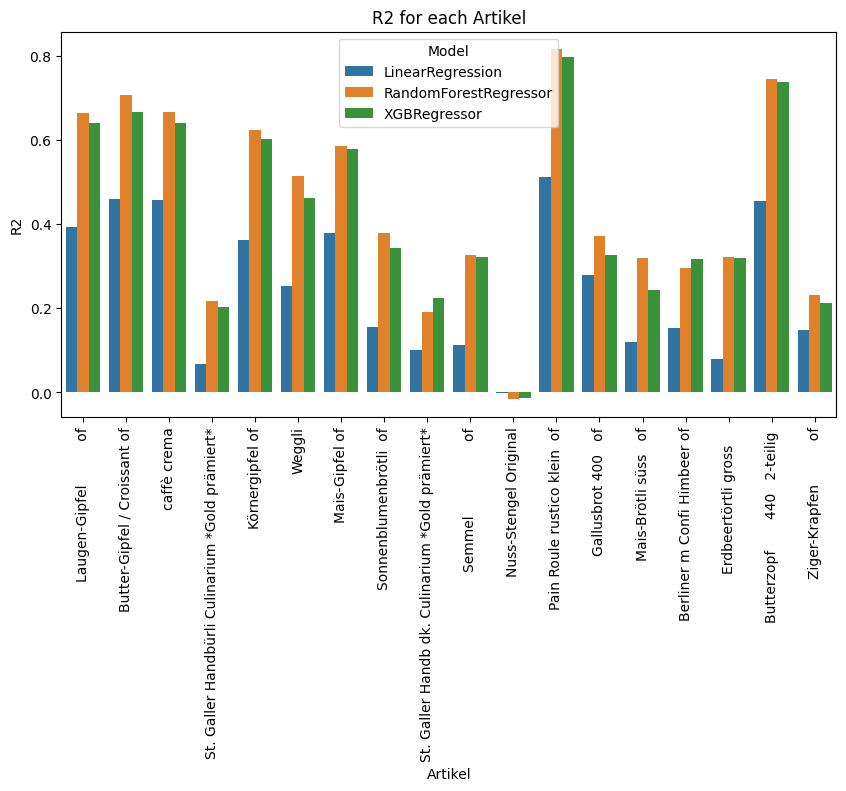

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='Artikel', y='R2', hue='modelname')
plt.title('R2 for each Artikel')
plt.ylabel('R2')
plt.xlabel('Artikel')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

### RMSE

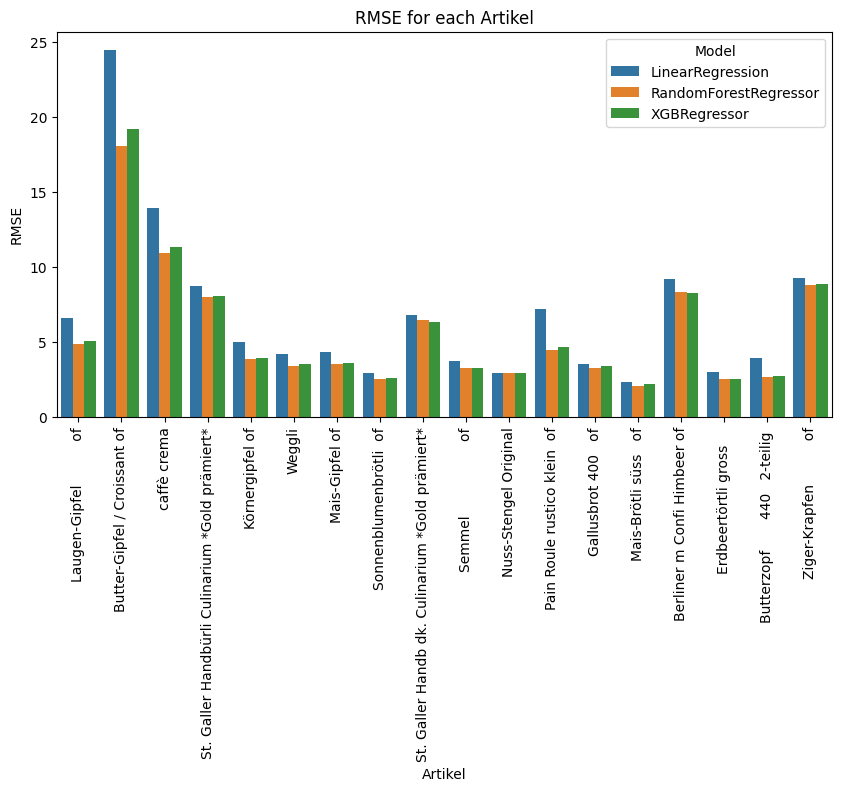

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=all_results, x='Artikel', y='RMSE', hue='modelname')
plt.title('RMSE for each Artikel')
plt.ylabel('RMSE')
plt.xlabel('Artikel')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

### Variable Importance

In [ ]:
for model_name, model_info in best_models.items():
    print(model_name)
    print(model_info)
    break

Laugen-Gipfel          of
{'LinearRegression': {'model': LinearRegression(), 'metrics': {'Artikel': 'Laugen-Gipfel          of', 'R2': 0.3925823382019865, 'RMSE': 6.546385893794799, 'MAPE': 0.30480053483280733, 'modelname': 'LinearRegression', 'score': 0.12477003669010997}}, 'RandomForestRegressor': {'model': RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10), 'metrics': {'Artikel': 'Laugen-Gipfel          of', 'R2': 0.6643423007064739, 'RMSE': 4.86638204663752, 'MAPE': 0.21425742861567465, 'modelname': 'RandomForestRegressor', 'score': 0.22952131771620476}}, 'XGBRegressor': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, 

In [ ]:
from functions import plot_variable_importance

for artikel, models in best_models.items():
    for model_name, model_info in models.items():
        plot_variable_importance(model_info['model'], X_train, model_name, artikel)

KeyError: 'metrics'

# Try Voting Regressor with best models

In [ ]:
# Create dictionary for best_models
best_models_voting = {}

# Dateframe for all metrics
all_results_voting = pd.DataFrame()

# Loop over articles
for artikel in all_articles:

    # Filter by Artikel
    data_filtered = data_enriched[data_enriched['Artikel'] == artikel].drop(['Artikel'], axis=1)

    X = data_filtered.drop(['Menge'], axis=1)
    y = data_filtered['Menge']

    # Split data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4153)

    models = [
        ('LinearRegression', LinearRegression(), {}),
        ('RandomForestRegressor', RandomForestRegressor(), rf_params),
        ('XGBRegressor', XGBRegressor(), xgb_params)
    ]

    # Initialize a dictionary for this artikel
    best_models_voting[artikel] = {}

    for name, model, params in models:

        if params:
            # Hyperparameter tuning using RandomizedSearchCV
            model_cv = RandomizedSearchCV(model, params, cv=5, n_iter=10, random_state=4153)
            model_cv.fit(X_train, y_train)
            best_model = model_cv.best_estimator_
        else:
            best_model = model
            best_model.fit(X_train, y_train)

        # Predict y
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Save results in a dictionary
        result = {'Artikel': artikel, 'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': name}

        # Calculate score
        result['score'] = calculate_score(result)

        # Add to results dataframe
        all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)    

        if name not in best_models_voting[artikel] or best_models_voting[artikel][name]['metrics']['RMSE'] > result['RMSE']:
            best_models_voting[artikel][name] = {'model': best_model, 'metrics': result}

    # Voting Regressor
    estimators = [(name, info['model']) for name, info in best_models_voting[artikel].items()]
    voting_regressor = VotingRegressor(estimators)
    voting_regressor.fit(X_train, y_train)

    # Predict y
    y_pred = voting_regressor.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Save results in a dictionary
    result = {'Artikel': artikel, 'R2': r2, 'RMSE': rmse, 'MAPE': mape, 'modelname': 'VotingRegressor'}

    # Calculate score
    result['score'] = calculate_score(result)

    # Add to results dataframe
    all_results_voting = pd.concat([all_results_voting, pd.DataFrame([result])], ignore_index=True)    
    
    # If it's the best model so far, save it
    if 'VotingRegressor' not in best_models_voting[artikel] or best_models_voting[artikel]['VotingRegressor']['metrics']['RMSE'] > result['RMSE']:
        best_models_voting[artikel]['VotingRegressor'] = {'model': voting_regressor, 'metrics': result}


KeyboardInterrupt: 

In [ ]:
import pickle

# Saving the objects:
with open('best_models_voting.pkl', 'wb') as f:  
    pickle.dump(best_models_voting, f)

In [ ]:
all_results

,Artikel,R2,RMSE,MAPE,modelname,score
0,Laugen-Gipfel of,0.392582,6.546386,0.304801,LinearRegression,0.124770
1,Laugen-Gipfel of,0.660557,4.893748,0.215382,RandomForestRegressor,0.227722
2,Laugen-Gipfel of,0.640090,5.039123,0.205045,XGBRegressor,0.220156
3,Butter-Gipfel / Croissant of,0.458513,24.432022,0.301028,LinearRegression,0.105295
4,Butter-Gipfel / Croissant of,0.707973,17.942261,0.202465,RandomForestRegressor,0.169366
5,Butter-Gipfel / Croissant of,0.666739,19.167166,0.197018,XGBRegressor,0.158486
6,caffè crema,0.457203,13.881888,0.480355,LinearRegression,0.109196
7,caffè crema,0.667684,10.861882,0.255731,RandomForestRegressor,0.174691
8,caffè crema,0.639335,11.315704,0.244255,XGBRegressor,0.166844
9,St. Galler Handbürli Culinarium *Gold prämiert*,0.066710,8.679693,0.519669,LinearRegression,0.026625


# Plot results

### Our Score

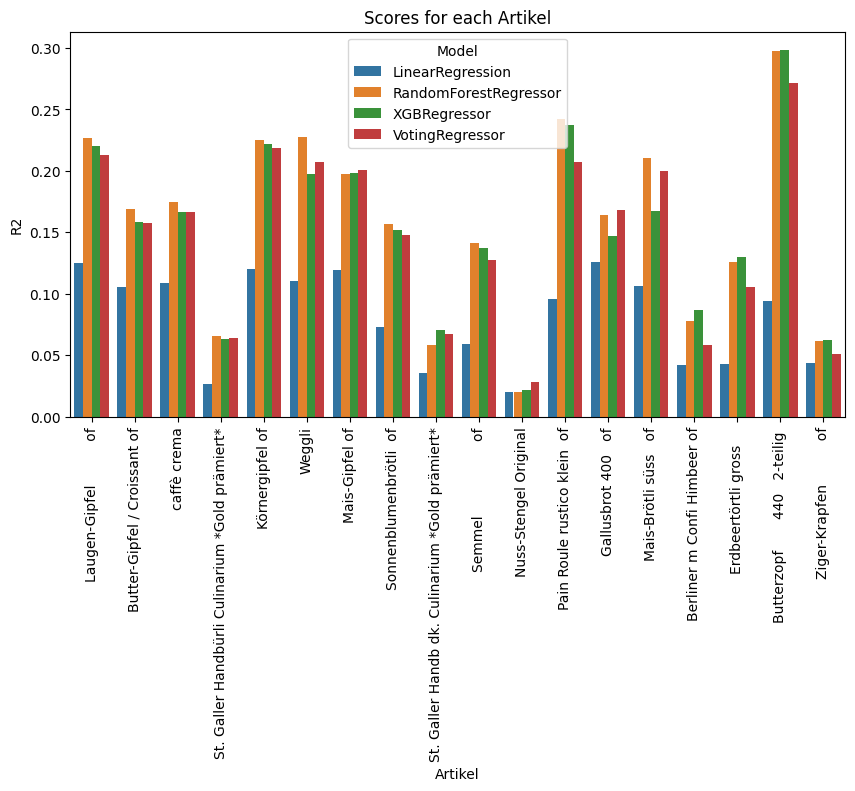

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=all_results_voting, x='Artikel', y='score', hue='modelname')
plt.title('Scores for each Artikel')
plt.ylabel('R2')
plt.xlabel('Artikel')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

### R2

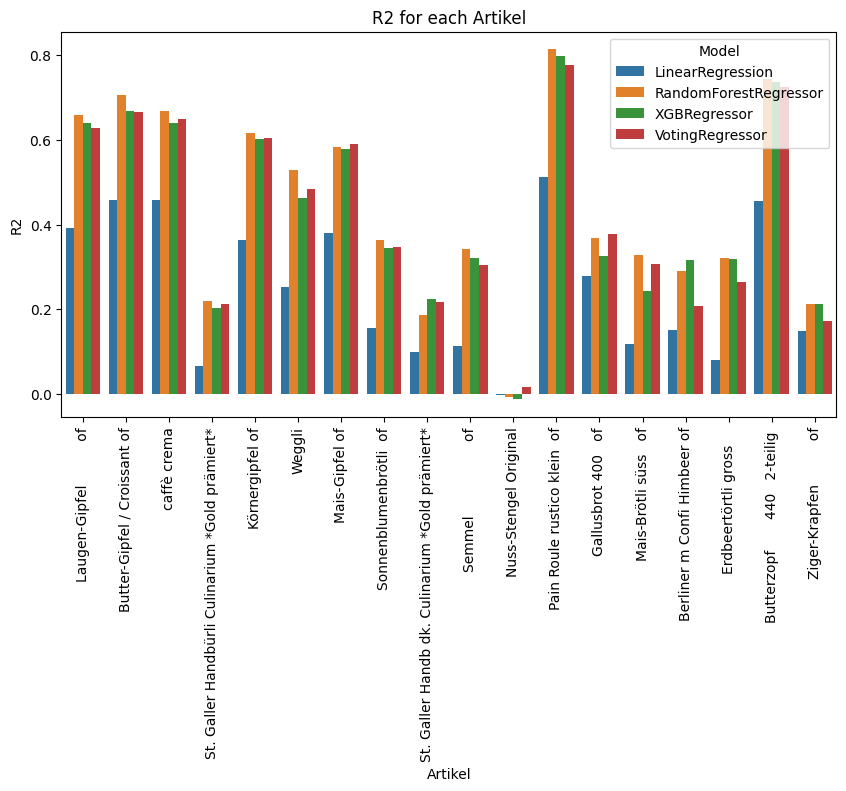

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=all_results_voting, x='Artikel', y='R2', hue='modelname')
plt.title('R2 for each Artikel')
plt.ylabel('R2')
plt.xlabel('Artikel')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

### RMSE

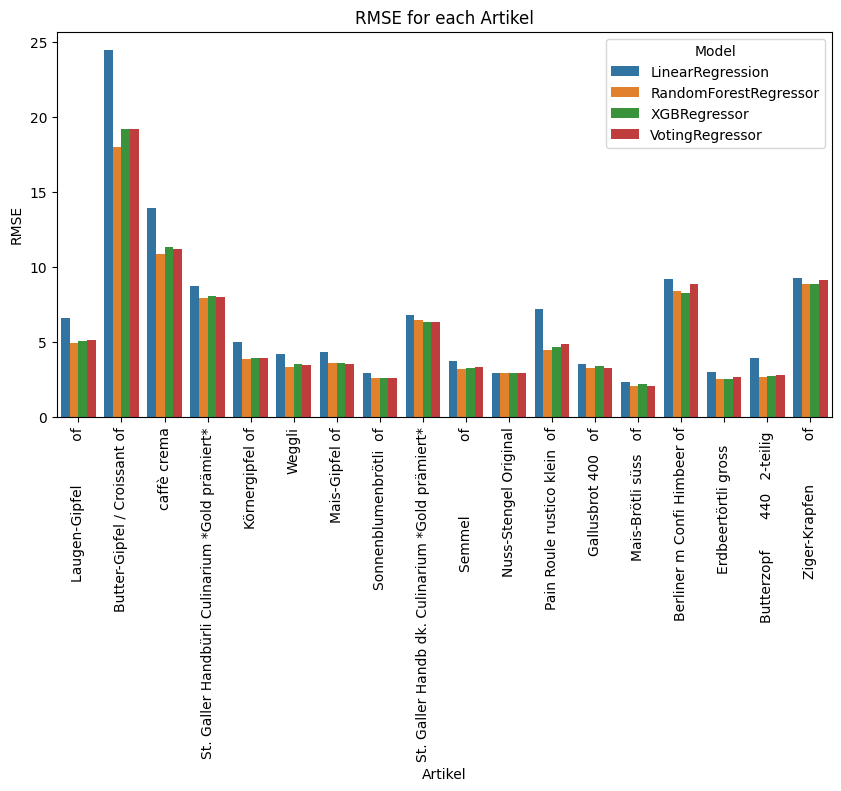

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=all_results_voting, x='Artikel', y='RMSE', hue='modelname')
plt.title('RMSE for each Artikel')
plt.ylabel('RMSE')
plt.xlabel('Artikel')
plt.xticks(rotation=90)
plt.legend(title='Model')
plt.show()

### Plot Variable Importance

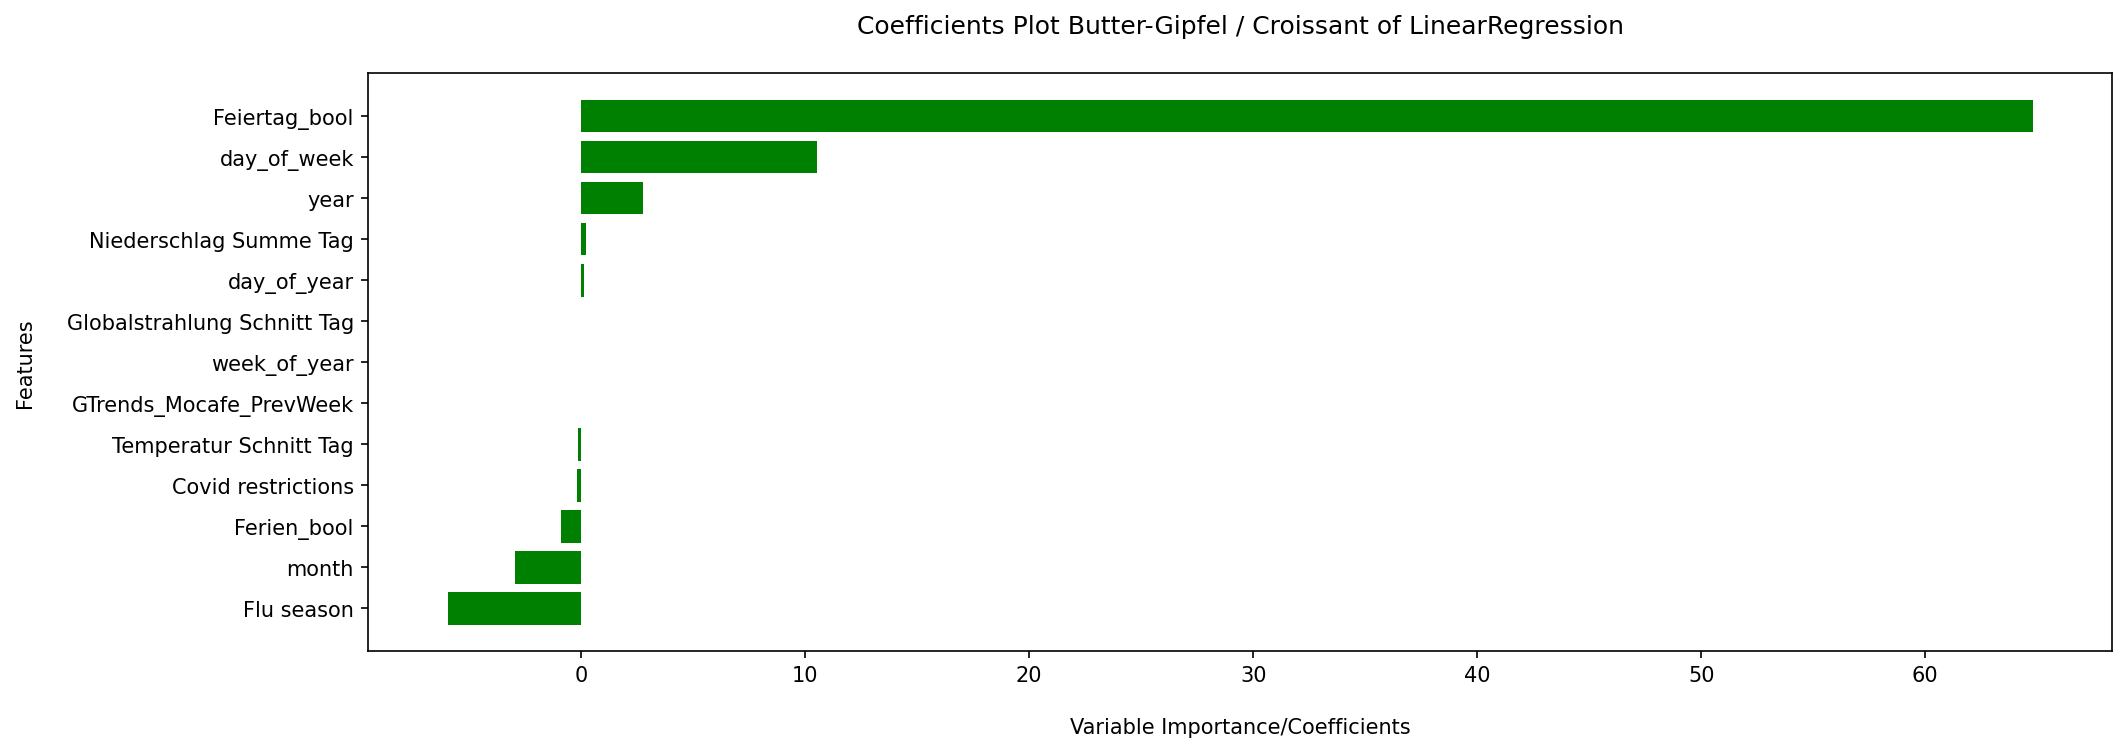

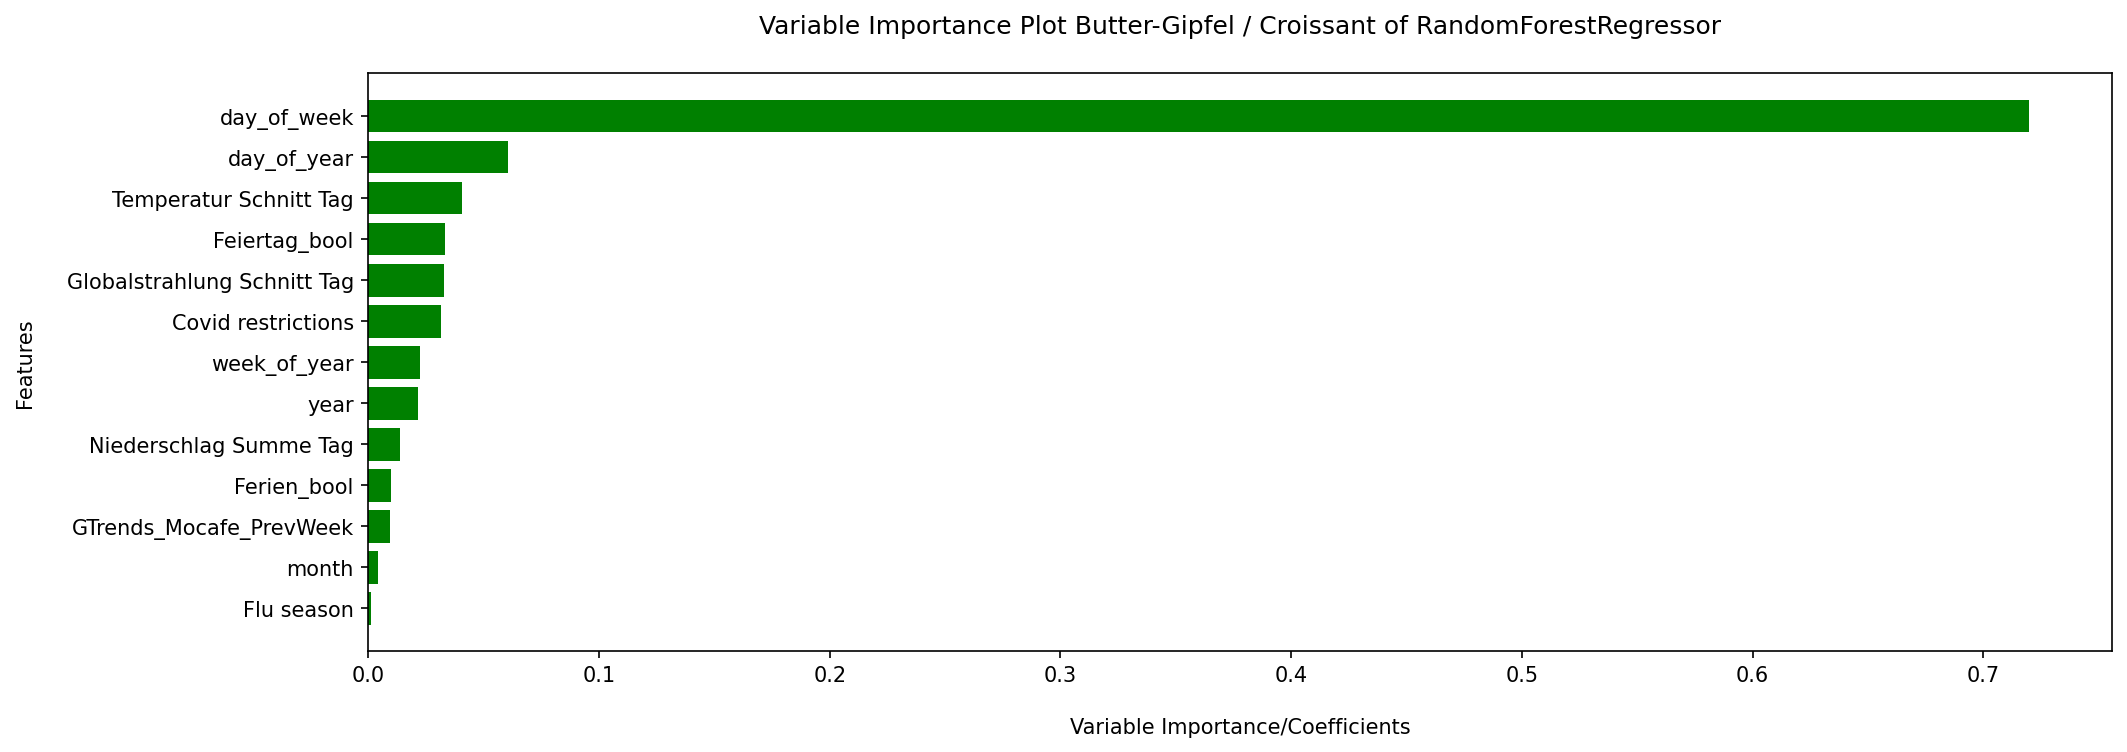

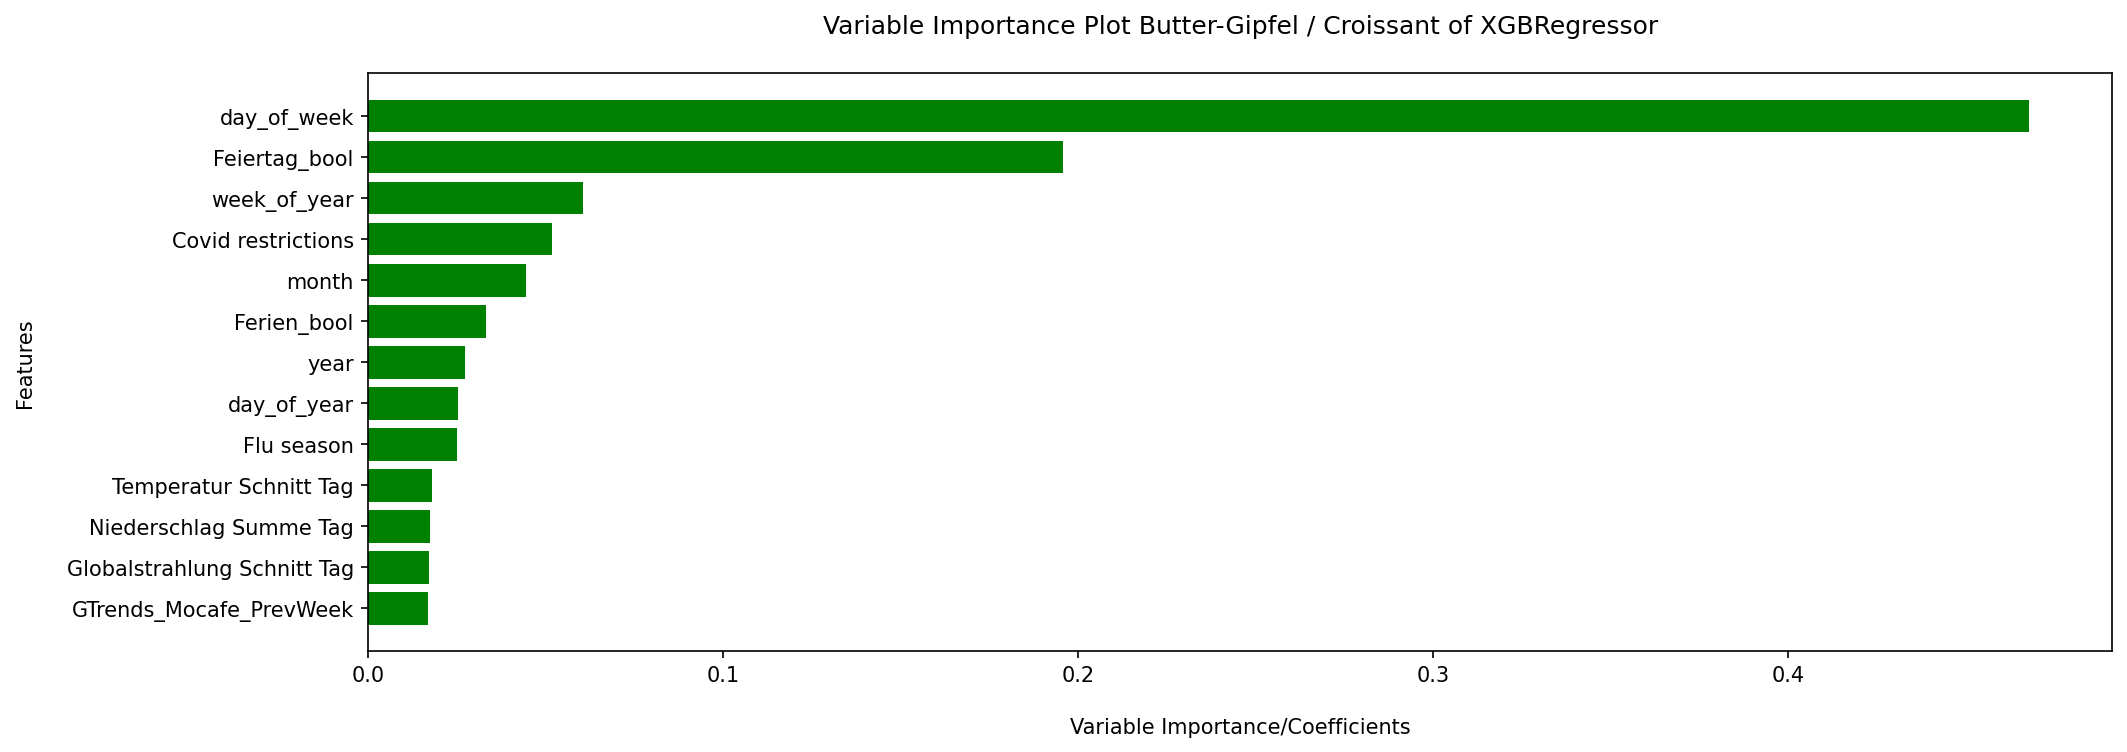

In [ ]:
for model_name, model_info in best_models.items():
    plot_variable_importance(model_info['model'], X_train, model_name, model_info['metrics']['Artikel'])